In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from os import path
from sklearn.decomposition import PCA
import sklearn
from glob import glob
import codecs
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
class Text(): 
    def __init__(self, filename, topWords, chunkSize=5000, maxPieces=1, 
                 equalPieces=False, maxLen=False): 
        with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as fdata:
            self.raw = fdata.read().lower()
        self.name = path.splitext(path.basename(filename))[0]
        
        # Use the filename to generate metadata like author name and date of publication. 
        # This assumes files named like austen-1811-mansfield.txt
        nameParts = self.name.split('-')
        self.author = nameParts[0]
        self.date = nameParts[1]
        
        self.tokens = nltk.tokenize.word_tokenize(self.raw) 
        
        if equalPieces: 
            # Break up the text into N equal-sized chunks, where n=maxPieces. 
            # Truncate the text at maxLen. 
            self.pieces = self.getEqualPieces(self.tokens, maxPieces, maxLen)
        else: 
            self.pieces = self.getPieces(self.tokens, chunkSize, maxPieces)

        # self.tokens = [word for word in self.tokens if word.isalpha()] # strip punctuation
        self.numPieces = len(self.pieces)
        self.chunkSize = len(self.pieces[0])
        
        if topWords:
            self.freqDists = []
            for piece in self.pieces: 
                mc = nltk.FreqDist(piece).most_common(topWords)
                d = {item[0]: item[1] for item in mc}
                self.freqDists.append(d)
        else: 
            self.freqDists = [nltk.FreqDist(piece) for piece in self.pieces]
        dfIndex = [self.name + '-' + str(i) for i in range(self.numPieces)]
        self.df = pd.DataFrame(self.freqDists, index=dfIndex).fillna(0)
        
        # I can't figure out how to get sklearn to CountVectorize on already-tokenized text, so 
        # putting this on hold for now. 
        #vectorizer = CountVectorizer(input='filename')
        #countMatrix = vectorizer.fit_transform(self.pieces).todense()
        #wordLabels = vectorizer.get_feature_names()
        #self.df = pd.DataFrame(countMatrix, columns=matrixLabels, index=textList)
        
    def __repr__(self): 
        return "Text %s: %s pieces of %s words each" % (self.name, self.numPieces, self.chunkSize)
    
    def __len__(self): 
        return len(self.tokens)
    
    def getPieces(self, text, length, num): 
        """ Chunk a text into `num` chunks of size `length`."""
        out = [] 
        for x in range(num): 
            out.append(text[length*x:length*(x+1)])
        return out
    
    def getEqualPieces(self, text, num, maxLen): 
        """ Divide a text into `num` equal pieces, also truncating at maxLen. """
        truncated = text[:maxLen]
        length = len(truncated)
        pieceSize = round(length / num)
        return self.getPieces(text, pieceSize, num)

In [3]:
class TextComparison(): 
    def __init__(self, filenames, numPieces=2, topWords=100):
        self.texts = [Text(filename, topWords=topWords) for filename in filenames]

        # Determine text with lowest word count. 
        # Truncate all other texts to this value. 
        cutoff = min(self.wordCounts.values())
        
        # TODO: make this so it doesn't have to instantiate a whole new text object each time. 
        # Maybe just get the word count some other way. 
        self.texts = [Text(filename, topWords=topWords, maxPieces=numPieces, equalPieces=True, maxLen=cutoff) for filename in filenames]
        
        self.dfs = [text.df for text in self.texts]
        self.df = pd.concat(self.dfs).fillna(0)
        self.labels = list(self.df.index)
        self.dates = [int(text.date) for text in self.texts]
        
    @property
    def pieceDates(self):
        dateList = []
        for text in self.texts: 
            theseDates = [int(text.date)] * text.numPieces
            dateList += theseDates
        return dateList

    @property
    def colors(self, by='date'): 
        if by == 'text': 
            colors = ['red', 'blue', 'green', 'yellow', 'purple'] * 10
            fullColorVec = []
            for i, text in enumerate(self.texts): 
                colorVec = [colors[i]] * text.numPieces
                fullColorVec += colorVec
        if by == 'date':    
            fullColorVec = plt.cm.rainbow(self.rescale(self.pieceDates, 0, 1))
        return fullColorVec
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    @property
    def wordCounts(self): 
        wordCountsDict = {text.name: len(text) for text in self.texts} 
        #pd.Series(wordCountsDict).plot(kind='bar')
        return wordCountsDict
    
    def doPCA(self, labels=False, saveTo=False): 
        pca = PCA(n_components=2)
        pcaTable = pca.fit_transform(self.df)
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        ax = plt.scatter(df[0], df[1], s=self.size, color=self.colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False).head()

# Thomas Mann

In [4]:
textList = glob('data/mann*')
t = TextComparison(textList)
textList

['data/mann-1903-tristan.txt',
 'data/mann-1903-tonio.txt',
 'data/mann-1897-kleine-herr.txt',
 'data/mann-1909-königliche.txt',
 'data/mann-1943-doktor.txt',
 'data/mann-1912-tod.txt',
 'data/mann-1902-gladius.txt',
 'data/mann-1901-buddenbrooks.txt']

,0,1,distance
mann-1897-kleine-herr-1,121.320022,23.681669,123.609745
mann-1909-königliche-1,97.496897,-64.302471,116.792349
mann-1943-doktor-0,-85.840445,-79.041740,116.688383
mann-1903-tonio-1,-33.503252,102.090446,107.447323
mann-1943-doktor-1,-91.983499,-37.912492,99.490306


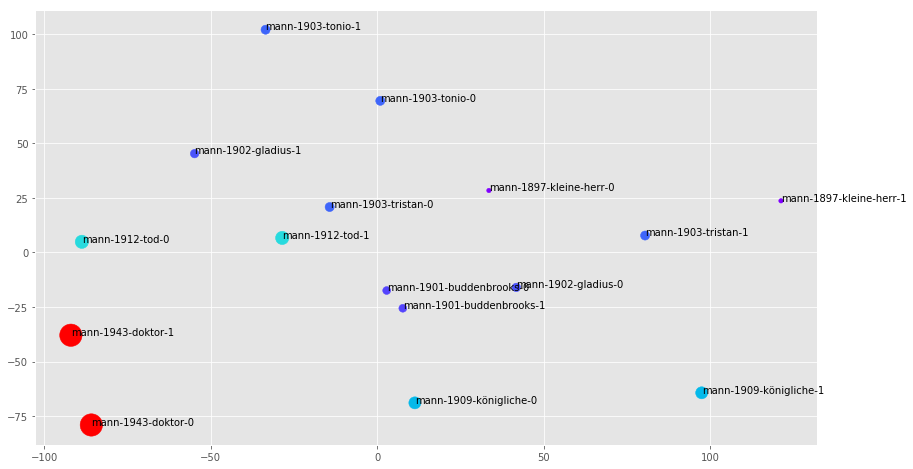

In [5]:
df = t.doPCA(labels=True)
df

# Marcel Proust

In [6]:
textList = glob('data/proust*')
t = TextComparison(textList)
textList

['data/proust-1920-guermantes.txt',
 'data/proust-1919-lombre.txt',
 'data/proust-1927-retrouve.txt',
 'data/proust-1923-prisonniere.txt',
 'data/proust-1921-sodome.txt',
 'data/proust-1925-albertine.txt',
 'data/proust-1913-swann.txt']

,0,1,distance
proust-1925-albertine-0,804.452101,-353.304621,878.616718
proust-1923-prisonniere-0,522.014751,307.541590,605.872288
proust-1923-prisonniere-1,91.925803,532.938172,540.808144
proust-1913-swann-0,-206.576898,-428.763707,475.933117
proust-1913-swann-1,-446.230485,-163.703828,475.311045


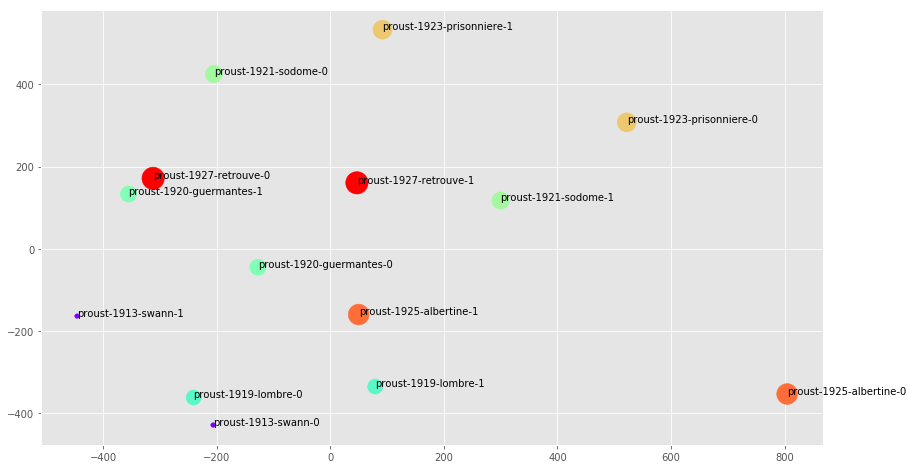

In [7]:
df = t.doPCA(labels=True)
df

# Arnold Bennett

In [8]:
textList = glob('data/bennett*')
t = TextComparison(textList)
textList

['data/bennett-1923-riceyman.txt',
 'data/bennett-1916-these-twain.txt',
 'data/bennett-1928-strange-vanguard.txt',
 'data/bennett-1929-accident.txt',
 'data/bennett-1910-clayhanger.txt',
 'data/bennett-1911-card.txt',
 'data/bennett-1908-old-wives.txt',
 'data/bennett-1930-imperial.txt',
 'data/bennett-1902-anna.txt',
 'data/bennett-1902-grand-babylon.txt']

,0,1,distance
bennett-1910-clayhanger-0,1844.401545,-593.458163,1937.526684
bennett-1910-clayhanger-1,1639.466897,-871.229687,1856.580963
bennett-1902-grand-babylon-0,246.051888,1244.527309,1268.617261
bennett-1902-grand-babylon-1,301.415043,1219.874395,1256.560611
bennett-1902-anna-1,235.628256,1187.465486,1210.617592


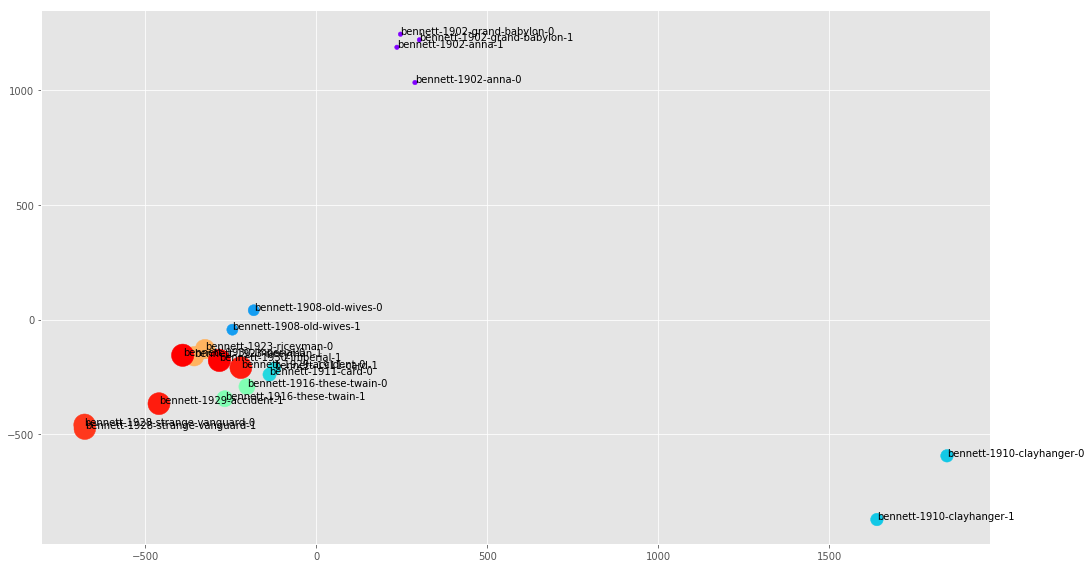

In [9]:
df = t.doPCA(labels=True, saveTo='bennett-2')
df

# Mary Augusta Ward (Mrs. Humphry Ward)

In [10]:
textList = glob('data/ward*')
t = TextComparison(textList)
textList

['data/ward-1913-mating.txt',
 'data/ward-1917-missing.txt',
 'data/ward-1900-eleanor.txt',
 'data/ward-1888-robert.txt',
 'data/ward-1915-success.txt',
 'data/ward-1908-diana.txt',
 'data/ward-1881-milly.txt',
 'data/ward-1903-lady-rose.txt',
 'data/ward-1916-connie.txt',
 'data/ward-1892-grieve.txt',
 'data/ward-1898-helbeck.txt',
 'data/ward-1896-tressady.txt',
 'data/ward-1920-harvest.txt',
 'data/ward-1894-marcella.txt',
 'data/ward-1905-marriage.txt']

,0,1,distance
ward-1881-milly-0,-404.596312,518.958993,658.039977
ward-1888-robert-1,509.411974,270.602801,576.824441
ward-1881-milly-1,-231.475069,492.489367,544.175049
ward-1900-eleanor-0,420.663496,-340.238674,541.036166
ward-1892-grieve-0,484.829382,197.966330,523.689027


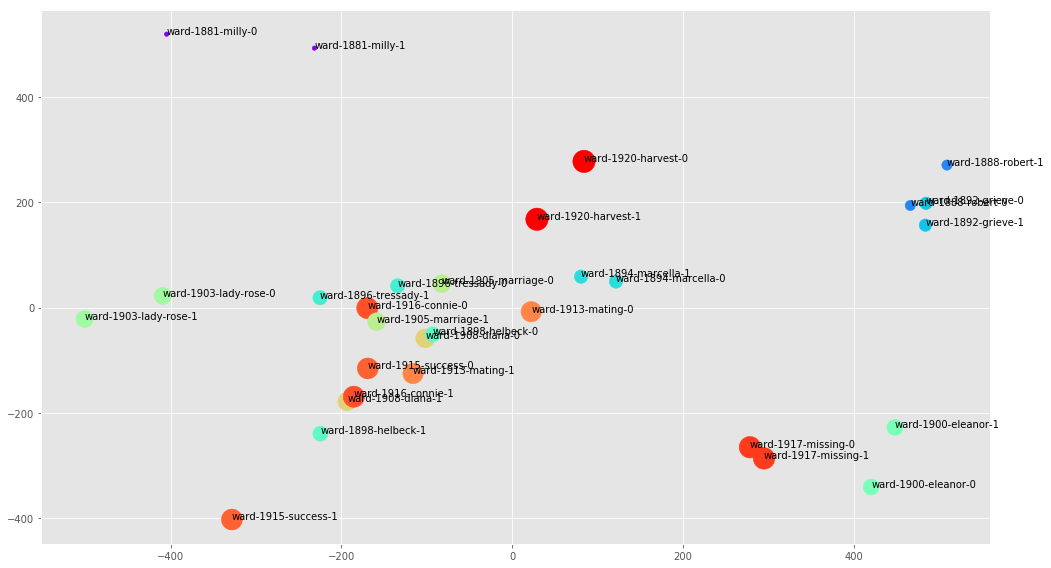

In [11]:
df = t.doPCA(labels=True, saveTo='ward-nomilly')
df

# Anthony Trollope

In [12]:
textList = glob('data/trollope*')
t = TextComparison(textList)
textList

['data/trollope-1875-way-we-live.txt',
 'data/trollope-1855-warden.txt',
 'data/trollope-1877-american-senator.txt',
 'data/trollope-1884-old-man.txt',
 'data/trollope-1869-phineas.txt',
 'data/trollope-1858-doctor-thorne.txt',
 'data/trollope-1857-barchester.txt',
 'data/trollope-1883-landleaguers.txt',
 'data/trollope-1864-house-at.txt',
 'data/trollope-1865-can-you-forgive.txt',
 'data/trollope-1861-framley.txt',
 'data/trollope-1867-last-chronicle.txt']

,0,1,distance
trollope-1855-warden-0,1268.582803,-148.330117,1277.225176
trollope-1857-barchester-0,938.026670,538.555508,1081.635830
trollope-1855-warden-1,960.834213,-131.649874,969.811360
trollope-1877-american-senator-1,-877.857701,299.996680,927.702620
trollope-1884-old-man-1,-879.666158,-193.646563,900.728339


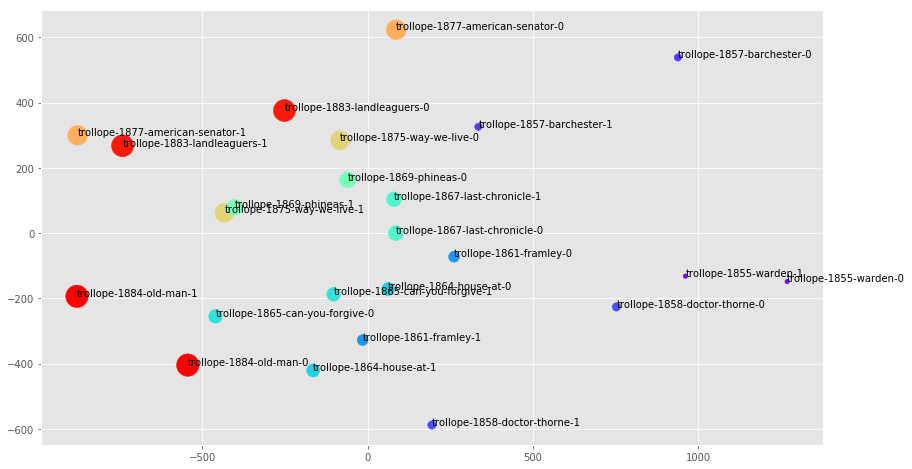

In [13]:
df = t.doPCA(labels=True)
df

# Wilkie Collins

In [14]:
textList = glob('data/collins*')
t = TextComparison(textList)
textList

['data/collins-1866-armadale.txt',
 'data/collins-1879-fallen-leaves.txt',
 'data/collins-1875-law-and-the-lady.txt',
 'data/collins-1885-evil-genius.txt',
 'data/collins-1870-man-and-wife.txt',
 'data/collins-1882-heart-and-science.txt',
 'data/collins-1868-the-moonstone.txt',
 'data/collins-1888-legacy-of-cain.txt',
 'data/collins-1860-woman-in-white.txt',
 'data/collins-1872-poor-miss-finch.txt',
 'data/collins-1886-guilty-river.txt',
 'data/collins-1862-no-name.txt',
 'data/collins-1854-hide-and-seek.txt',
 'data/collins-1876-two-destinies.txt',
 'data/collins-1874-dead-alive.txt',
 'data/collins-1881-black-robe.txt',
 'data/collins-1879-haunted-hotel.txt',
 'data/collins-1856-dead-secret.txt',
 'data/collins-1852-basil.txt',
 'data/collins-1873-new-magdalen.txt']

,0,1,distance
collins-1854-hide-and-seek-0,-372.136510,-255.175467,451.220679
collins-1875-law-and-the-lady-1,396.372418,64.097891,401.521647
collins-1888-legacy-of-cain-1,390.271540,88.586306,400.199211
collins-1886-guilty-river-1,323.574900,-131.397103,349.236187
collins-1886-guilty-river-0,292.673516,-160.745267,333.911407


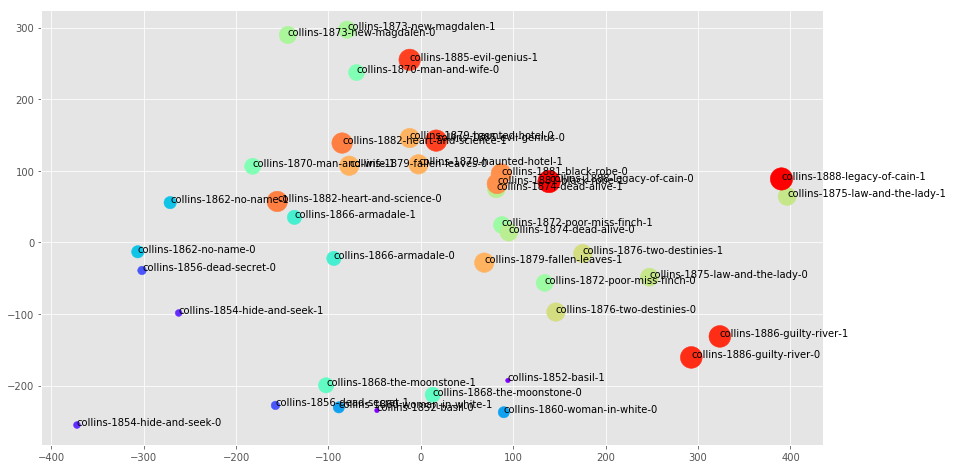

In [15]:
df = t.doPCA(labels=True)
df

# Walter Scott

In [18]:
textList = glob('data/scott*')
t = TextComparison(textList)
textList

['data/scott-1815-guy-mannering.txt',
 'data/scott-1825-talisman.txt',
 'data/scott-1828-maid-of-perth.txt',
 'data/scott-1829-anne.txt',
 'data/scott-1818-heart-of-midlothian.txt',
 'data/scott-1824-redgauntlet.txt',
 'data/scott-1814-waverly.txt',
 'data/scott-1832-count-robert.txt',
 'data/scott-1816-old-mortality.txt',
 'data/scott-1819-legend-of-montrose.txt',
 'data/scott-1816-black-dwarf.txt',
 'data/scott-1819-ivanhoe.txt',
 'data/scott-1820-the-abbot.txt',
 'data/scott-1823-quentin.txt',
 'data/scott-1821-pirate.txt',
 'data/scott-1816-antiquary.txt',
 'data/scott-1817-rob-roy.txt',
 'data/scott-1821-kenilworth.txt',
 'data/scott-1825-bethrothed.txt',
 'data/scott-1826-woodstock.txt',
 'data/scott-1823-st-ronans-well.txt',
 'data/scott-1819-bride-of-lammermoor.txt',
 'data/scott-1816-old-mortality.tt',
 'data/scott-1831-castle-dangerous.txt']

,0,1,distance
scott-1823-st-ronans-well-1,768.624548,818.944703,1123.144747
scott-1832-count-robert-0,-677.637890,346.284589,760.990227
scott-1817-rob-roy-1,734.508523,-162.340134,752.234731
scott-1825-talisman-0,-641.369296,-252.852189,689.411926
scott-1826-woodstock-0,265.270714,607.381386,662.782543


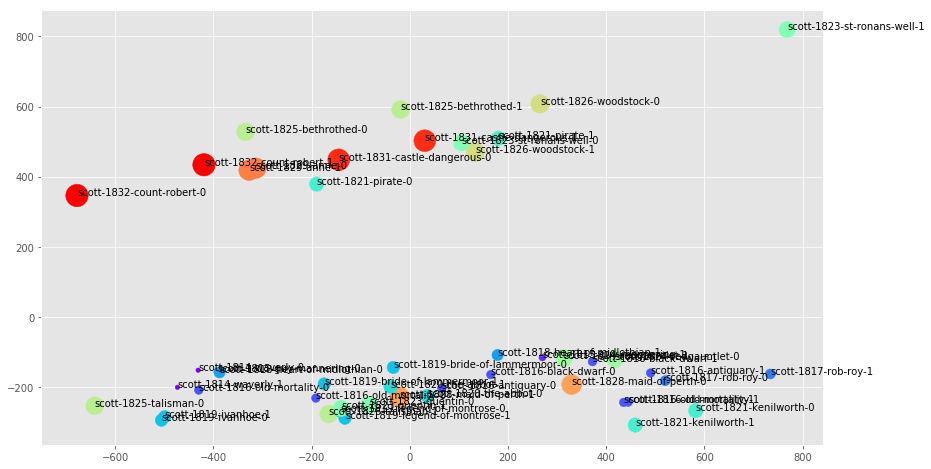

In [19]:
df = t.doPCA(labels=True)
df